# TP3 - Parte 4: Consignas Adicionales

Se pide sumar al menos 2 puntos adicionales. Para esto, me resultaron interesantes las siguientes 3 consignas, que se relacionan un poco con algunas de las cosas que realicé durante las tres partes anteriores:

1) Resolver el problema realizando un embedding para el campo text y KNN (No se incluye en los dos modelos previos) (1 puntos)
2) Graficar y analizar, para alguno de los modelos de la parte III, los siguientes resultados (1 punto):
    - Curva ROC, explicando la selección de corte.
    - Feature importance.
    - Matriz de confusión.
3) Realizar un embedding para el campo text y visualizarlo con alguna técnica de reducción de visualizaciones distinta a PCA. En base a la visualización, ¿Sería posible predecir el target con este embedding? (2 punto)

## Imports y descarga de dependencias

In [ ]:
import pandas as pd
import numpy as np
import umap

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

## Load de datos:

Cargo los X e Y:

In [ ]:
X_train = pd.read_csv("../data/processed/X_train_procesado.csv", index_col=0)
y_train = pd.read_csv("../data/processed/y_train_procesado.csv", index_col=0)

X_validation = pd.read_csv("../data/processed/X_validation_procesado.csv", index_col=0)
y_validation = pd.read_csv("../data/processed/y_validation_procesado.csv", index_col=0)

X_test = pd.read_csv("../data/processed/X_test_procesado.csv", index_col=0)

Voy a utilizar el embedding que hicimos con BERTweet, como vimos antes:

In [ ]:
df_train_bert = pd.read_csv("../data/processed/df_train_bert.csv", index_col=0)
df_valid_bert = pd.read_csv("../data/processed/df_valid_bert.csv", index_col=0)

In [ ]:
X_train = pd.concat([X_train, df_train_bert], axis=1)
X_validation = pd.concat([X_validation, df_valid_bert], axis=1)

Dropeo los textos porque ya los embedee con BERTweet

In [ ]:
X_train = X_train.drop(columns=["text"])
X_validation = X_validation.drop(columns=["text"])

Agrego las columnas latitud y longitud que extraímos con Nominatim

In [ ]:
X_validation_latlon = pd.read_csv("../data/processed/X_validation_latlon.csv", index_col=0)
X_train_latlon = pd.read_csv("../data/processed/X_train_latlon.csv", index_col=0)
X_test_latlon = pd.read_csv("../data/processed/X_test_latlon.csv", index_col=0)

Y mergeamos latlon con los X correspondientes:

In [ ]:
X_train = X_train.merge(X_train_latlon, how="left", left_index=True, right_index=True)

In [ ]:
X_validation = X_validation.merge(X_validation_latlon, how="left", left_index=True, right_index=True)

In [ ]:
X_test = X_test.merge(X_test_latlon, how="left", left_index=True, right_index=True)

Finalmente, agregamos las keyword-related features que calculamos para el Random Forest:

In [ ]:
X_train_keyword_feats = pd.read_csv("../data/processed/X_train_keyword_features.csv", index_col=0)

In [ ]:
X_validation_keyword_feats = pd.read_csv("../data/processed/X_validation_keyword_features.csv", index_col=0)

In [ ]:
X_test_keyword_feats = pd.read_csv("../data/processed/X_test_keyword_features.csv", index_col=0)

Y mergeamos:

In [ ]:
X_train = X_train.merge(X_train_keyword_feats, how="left", left_index=True, right_index=True)

In [ ]:
X_validation = X_validation.merge(X_validation_keyword_feats, how="left", left_index=True, right_index=True)

In [ ]:
X_test = X_test.merge(X_test_keyword_feats, how="left", left_index=True, right_index=True)

## 1. Embedding de text y KNN

La motivación para realizar este punto surge del mal desempeño que tuvo mi primer modelo KNN, tan malo que decidí descartarlo y realizar otros dos modelos distintos para la parte anterior. Entonces, luego de generar las nuevas features. Me pareció obvio intentar de nuevo con el modelo KNN, siendo que:
- Me pareció interesante comparar si el embedding BERT es mejor que el TF-IDF que realicé para KNN, por un lado, mejora mucho tener una cantidad de features fija de 768, pero además, debería haber una mejora en las distancias entre palabras porque entiendo que este embedding retiene relaciones semánticas entre las palabras mediante las distancias.
- Agregamos las features de latitud y longitud, que serán muy útiles para calcular las distancias, ya que tienen una correlación directa con la distancia entre los tweets.
- Además saqué estadísticas sobre la categórica keyword, y esto podría ser útil para KNN porque los datos con estadísticos cercanos en estas columnas tendrán Target Mean Encodings y Cantidad de Apariciones similares.

Ya tenemos el embedding de text realizado, solo queda escalar los datos para que no se distorcionen las distancias, generar el modelo KNN y ver los resultados:

In [ ]:
X_train.head(1)

,keyword,tweet_length,num_uppercase_letters,num_uppercase_words,num_special_chars,num_digits,standard_location,num_hashtags,num_urls,num_tags,...,bert_765,bert_766,bert_767,lat,lon,apariciones,target_mean,ratio,ratio_lower,ratio_upper
id,,,,,,,,,,,,,,,,,,,,,
4392,earthquake,medium_short,40,7,15,5,global edition,1,2,0,...,-0.074878,0.089108,0.028698,NaN,NaN,32.0,0.8125,39.384615,33.687747,47.400403


Antes del escalado, tenemos que ver qué hacemos con las columnas keyword, tweet_length y standard location que son las columnas no numéricas.

In [ ]:
X_train.select_dtypes(exclude=['number']).columns

Index(['keyword', 'tweet_length', 'standard_location'], dtype='object')

- Keyword la voy a dropear porque ya tengo el embedding hecho con keyword_feats.
- Sobre tweet_length, para KNN era mucho mejor tener directamente cantidad de palabras/caracteres. Asique voy a dropearla también en lugar de hacer un OneHot que no va a aportar tanto.
- Para standard_location ya tenemos latitud y longitud, pero para saar más información voy a aplicar otra vez el mismo embedding que apliqué sobre Keyword.

In [ ]:
X_train = X_train.drop(columns=['keyword','tweet_length'])
X_validation = X_validation.drop(columns=['keyword','tweet_length'])
X_test = X_test.drop(columns=['keyword','tweet_length'])

### Embedding de standard_location

Mismo procedimiento que hicimos para keyword, pero con standard_location.

In [ ]:
train_df = X_train.copy()
train_df['target'] = y_train.values

In [ ]:
global_mean = train_df['target'].mean()
global_mean

np.float64(0.4297208538587849)

In [ ]:
stats_df = train_df.groupby('standard_location')['target'].agg(['mean','count','std']).reset_index()
stats_df = stats_df.rename(columns={'mean':'location_target_mean','count':'location_apariciones','std':'location_target_std'})
stats_df

,standard_location,location_target_mean,location_apariciones,location_target_std
0,",",0.00,1,NaN
1,"1 vacation destination,hawaii",1.00,1,NaN
2,10 steps ahead cloud 9,1.00,1,NaN
3,10jul,0.00,1,NaN
4,110 taron squad,0.00,1,NaN
...,...,...,...,...
1438,臺南市,0.00,1,NaN
1439,臺灣,0.00,7,0.000000
1440,香港 Hong Kong,0.75,4,0.500000
1441,대한민국,0.00,3,0.000000


In [ ]:
stats_df.location_apariciones.describe()

,location_apariciones
count,1443.000000
mean,2.785863
std,8.019776
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,149.000000


Para no tener intervalos exagerados para keywords con pocas apariciones, voy a aplicar un suavizado para keywords con menos de 20 apariciones (aprox casi todo el primer cuantil):

In [ ]:
k_smooth = 5  # parámetro de suavizado
def smooth_mean(row):
    if row['location_apariciones'] < 20:
        return (row['location_apariciones'] * row['location_target_mean'] + k_smooth * global_mean) / (row['location_apariciones'] + k_smooth)
    else:
        return row['location_target_mean']

La formula del suavizado es:
`target_mean_smoothed = (n⋅target_mean+k⋅global_mean)/(n+k)`
Y lo usamos para que si hay una keyword con una única aparición y target 1. Su mean es 1, pero no queremos que el modelo le de a todas las nuevas apariciones un predict de 1. Entonces lo suavizamos acercandolo al target mean global de todo el set de training.

In [ ]:
stats_df['location_target_mean'] = stats_df.apply(smooth_mean, axis=1)

Por qué no usamos .map()? En este caso, la función smooth_mean necesita mirar varias columnas de la fila (apariciones y target_mean) para decidir si aplica suavizado o no.

Ahora calculamos los IC 95% con la formula encontrada en este [post](https://stackoverflow.com/questions/53519823/confidence-interval-in-python-dataframe).

In [ ]:
z = 1.96
stats_df['location_ci95_low'] = stats_df['location_target_mean'] - z * (stats_df['location_target_std'] / np.sqrt(stats_df['location_apariciones']))
stats_df['location_ci95_high'] = stats_df['location_target_mean'] + z * (stats_df['location_target_std'] / np.sqrt(stats_df['location_apariciones']))

In [ ]:
stats_df['location_ratio'] = stats_df['location_apariciones'] / stats_df['location_target_mean']
stats_df['location_ratio_lower'] = stats_df['location_apariciones'] / stats_df['location_ci95_high']
stats_df['location_ratio_upper'] = stats_df['location_apariciones'] / stats_df['location_ci95_low']

In [ ]:
stats_df.head(4)

,standard_location,location_target_mean,location_apariciones,location_target_std,location_ci95_low,location_ci95_high,location_ratio,location_ratio_lower,location_ratio_upper
0,",",0.358101,1,NaN,NaN,NaN,2.792511,NaN,NaN
1,"1 vacation destination,hawaii",0.524767,1,NaN,NaN,NaN,1.905606,NaN,NaN
2,10 steps ahead cloud 9,0.524767,1,NaN,NaN,NaN,1.905606,NaN,NaN
3,10jul,0.358101,1,NaN,NaN,NaN,2.792511,NaN,NaN


Tenemos infs asique los reemplazamos porque dividimos por 0:

In [ ]:
MAX_F = np.finfo(np.float32).max   # ≈ 3.4e38
MIN_F = np.finfo(np.float32).min   # ≈ -3.4e38

stats_df = stats_df.replace([np.inf],  MAX_F)
stats_df = stats_df.replace([-np.inf], MIN_F)

In [ ]:
stats_df.head(4)

,standard_location,location_target_mean,location_apariciones,location_target_std,location_ci95_low,location_ci95_high,location_ratio,location_ratio_lower,location_ratio_upper
0,",",0.358101,1,NaN,NaN,NaN,2.792511,NaN,NaN
1,"1 vacation destination,hawaii",0.524767,1,NaN,NaN,NaN,1.905606,NaN,NaN
2,10 steps ahead cloud 9,0.524767,1,NaN,NaN,NaN,1.905606,NaN,NaN
3,10jul,0.358101,1,NaN,NaN,NaN,2.792511,NaN,NaN


Ahora, podemos agregar estas features a X_train:

In [ ]:
X_train = X_train.join(
    stats_df.set_index("standard_location")[["location_apariciones","location_target_mean","location_ratio","location_ratio_lower","location_ratio_upper"]],
    on="standard_location",
    how="left"
)

Y para validation y test, vamos a usar un apply porque vamos a chequear handlear el caso en que aparezca una keyword nueva con valores default:

In [ ]:
mapping = stats_df.set_index('standard_location')[['location_apariciones','location_target_mean','location_ratio','location_ratio_lower','location_ratio_upper']].to_dict(orient='index')

In [ ]:
location_ratio_global = stats_df['location_ratio'].mean()
location_ratio_lower_global = stats_df['location_ratio_lower'].mean()
location_ratio_upper_global = stats_df['location_ratio_upper'].mean()

In [ ]:
def map_features(row):
    if row['standard_location'] in mapping:
        return pd.Series(mapping[row['standard_location']])
    else:
        # keywords nuevas
        return pd.Series({
            'location_apariciones': 0,
            'location_target_mean': global_mean,
            'location_ratio': location_ratio_global,
            'location_ratio_lower': location_ratio_lower_global,
            'location_ratio_upper': location_ratio_upper_global
        })

In [ ]:
X_validation_location_feats = X_validation.apply(map_features, axis=1)
X_validation_location_feats.head(2)

,location_apariciones,location_target_mean,location_ratio,location_ratio_lower,location_ratio_upper
id,,,,,
8266,0.0,0.429721,6.790193,12.417238,-30.011054
10724,0.0,0.429721,6.790193,12.417238,-30.011054


In [ ]:
X_validation = pd.concat([X_validation, X_validation_location_feats], axis=1)

In [ ]:
X_test_location_feats = X_test.apply(map_features, axis=1)
X_test_location_feats.head(2)

,location_apariciones,location_target_mean,location_ratio,location_ratio_lower,location_ratio_upper
id,,,,,
0,0.0,0.429721,6.790193,12.417238,-30.011054
2,0.0,0.429721,6.790193,12.417238,-30.011054


In [ ]:
X_test = pd.concat([X_test, X_test_location_feats], axis=1)

### Escalado y KNN

In [ ]:
scaler = StandardScaler()

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
params = [
    {'n_neighbors': [3, 5, 7, 9, 11]},
    {'weights': ['uniform', 'distance']},
    {'p': [1, 2]}
]

In [ ]:
rs_knn = RandomizedSearchCV(knn, param_distributions=params, n_iter=5, random_state=420, cv=5, scoring='f1', n_jobs=-1, verbose=1000)

In [ ]:
cols_con_nulos = X_train.columns[X_train.isnull().any()]
cols_con_nulos

Index(['standard_location', 'lat', 'lon', 'apariciones', 'target_mean',
       'ratio', 'ratio_lower', 'ratio_upper', 'location_apariciones',
       'location_target_mean', 'location_ratio', 'location_ratio_lower',
       'location_ratio_upper'],
      dtype='object')

Tengo columnas numéricas con nulos, que no puedo darle a KNN, asique quiero reemplazar los nulos por valores con sentido.
1. standard_location lo dejo con nulos porque lo voy a dropear.
2. lat y lon los calculo como el lat y lon promedio de las filas que tengan el mismo standard_location, y si no puedo hacer esto entonces lo reemplazo por lat y lon promedio de todo el dataframe.
3. Todas las demás columnas las reemplazo por el promedio global de esa columna.

In [ ]:
lat_mean_by_loc = X_train.groupby('standard_location')['lat'].transform('mean')
lon_mean_by_loc = X_train.groupby('standard_location')['lon'].transform('mean')

In [ ]:
X_train['lat'] = X_train['lat'].fillna(lat_mean_by_loc)
X_train['lon'] = X_train['lon'].fillna(lon_mean_by_loc)

In [ ]:
X_train['lat'] = X_train['lat'].fillna(X_train['lat'].mean())
X_train['lon'] = X_train['lon'].fillna(X_train['lon'].mean())

In [ ]:
columnas_restantes = [
    'apariciones', 'target_mean', 'ratio', 'ratio_lower', 'ratio_upper',
    'location_apariciones', 'location_target_mean', 'location_ratio',
    'location_ratio_lower', 'location_ratio_upper'
]

for col in columnas_restantes:
    X_train[col] = X_train[col].fillna(X_train[col].mean())

Y hacemos lo mismo en Validation para poder hacer el predict, obviamente usando los mismos means calculados en train, ya que no podemos usar los de validation.

In [ ]:
X_validation['lat'] = X_validation['lat'].fillna(lat_mean_by_loc)
X_validation['lon'] = X_validation['lon'].fillna(lon_mean_by_loc)

In [ ]:
# Muy importante aca hacer fillna con los promedios de train. Capaz me conviene definir una variable
# Eto e muy peliloso
X_validation['lat'] = X_validation['lat'].fillna(X_train['lat'].mean())
X_validation['lon'] = X_validation['lon'].fillna(X_train['lon'].mean())

In [ ]:
columnas_restantes = [
    'apariciones', 'target_mean', 'ratio', 'ratio_lower', 'ratio_upper',
    'location_apariciones', 'location_target_mean', 'location_ratio',
    'location_ratio_lower', 'location_ratio_upper'
]

for col in columnas_restantes:
    X_validation[col] = X_validation[col].fillna(X_train[col].mean()) # Atenti, otro muy peliloso

Ahora dropeamos todas las columnas no numericas y las demás las escalamos con un ColumnTransformer

In [ ]:
cols_numericas = X_train.select_dtypes(include=['number']).columns
len(cols_numericas)

789

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", scaler, cols_numericas)
    ],
    remainder='drop'
)

Ahora aplicamos el transformer y probamos KNN:

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_validation_transformed = preprocessor.transform(X_validation)

In [ ]:
rs_knn.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions=[{'n_neighbors': [3, 5, 7, 9, 11]},
                                        {'weights': ['uniform', 'distance']},
                                        {'p': [1, 2]}],
                   random_state=420, scoring='f1', verbose=1000)

In [ ]:
model = rs_knn.best_estimator_

In [ ]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
y_train_pred_rs = model.predict(X_train_transformed)
y_validation_pred_rs = model.predict(X_validation_transformed)

In [ ]:
f1_train_rs = f1_score(y_train, y_train_pred_rs, average='weighted')
f1_val_rs = f1_score(y_validation, y_validation_pred_rs, average='weighted')
gap = f1_train_rs - f1_val_rs

print(f"Modeloo KNN: F1 train = {f1_train_rs:.4f}, F1 val = {f1_val_rs:.4f}, gap = {gap:.4f}")

Modeloo KNN: F1 train = 0.8270, F1 val = 0.7358, gap = 0.0912


Genial! Tuvimos un puntaje de 0.735, no es algo tan bueno, pero es una mejora enorme comparandolo con el score del primer modelo KNN que hice, que daba un score al rededor de 0.60-0.62

## 2. Analizando los modelos de la parte 3

## 3. Reducción de dimensiones con UMAP

La motivación para realizar este punto surge también de mi primer modelo KNN. En la búsqueda de optimizar ese primer modelo, utilice UMAP para reducir las dimensiones de TF-IDF, pero sin mucho resultado. Entonces, para este punto me parece interesante hacer la reducción con UMAP a 2 dimensiones del embedding BERT y generar la visualización.

Luego, si hubiera tiempo, haría la misma reducción con el embedding TF-IDF y podriamos compararlas.

In [ ]:
umap_reducer = umap.UMAP(n_components=3, random_state=42, n_jobs=-1)

Nota: setee n_jobs a -1 para paralelismo pero si le asigno random_state se overridea, asique si tarda mucho en ejecutar voy a eliminar el random_state para poder tener paralelismo y acelerar el computo.

In [ ]:
bert_cols = X_train.columns[X_train.columns.str.contains("bert", case=False)]
print(bert_cols)

Index(['bert_0', 'bert_1', 'bert_2', 'bert_3', 'bert_4', 'bert_5', 'bert_6',
       'bert_7', 'bert_8', 'bert_9',
       ...
       'bert_758', 'bert_759', 'bert_760', 'bert_761', 'bert_762', 'bert_763',
       'bert_764', 'bert_765', 'bert_766', 'bert_767'],
      dtype='object', length=768)


In [ ]:
emb_matrix = X_train[bert_cols].values

Instanciamos UMAP de 2 y 3 dimensiones para lso gráficos:

In [ ]:
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=123
)

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=123
)

In [ ]:
emb_2d = umap_2d.fit_transform(emb_matrix)
emb_3d = umap_3d.fit_transform(emb_matrix)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Grafico 2D

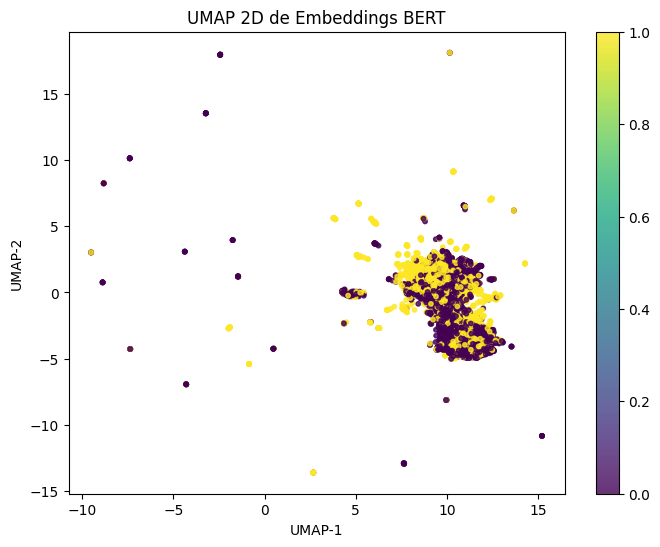

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=y_train.values,
    s=10,
    alpha=0.8
)

plt.colorbar(scatter)
plt.title("UMAP 2D de Embeddings BERT")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

### Grafico 3D

En primera instancia podemos hacer un gráfico 3D básico para ver la distribución de los puntos en el espacio:

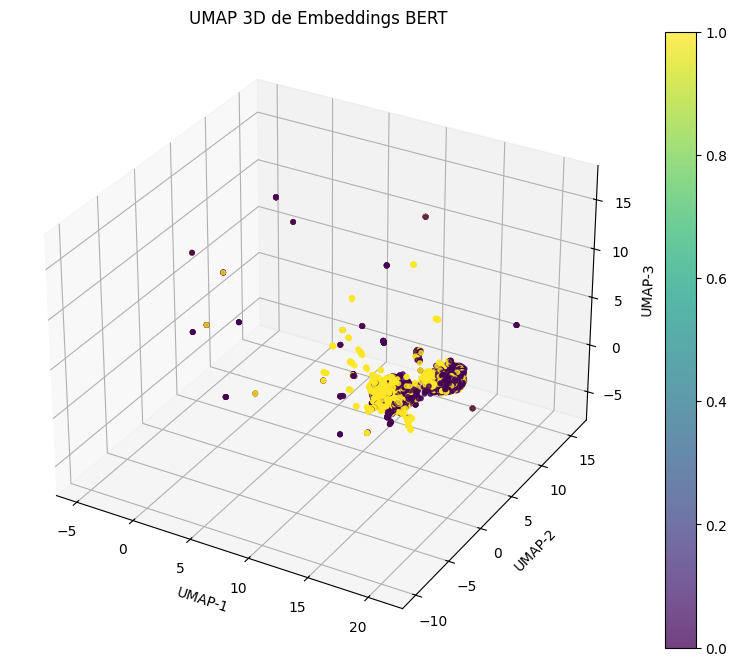

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    emb_3d[:, 0],
    emb_3d[:, 1],
    emb_3d[:, 2],
    c=y_train,
    s=10,
    alpha=0.75
)

fig.colorbar(p)
ax.set_title("UMAP 3D de Embeddings BERT")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.show()

Pero esto no nos deja hacer cortes planos claros del mismo para ver si hay alguna separación entre los targets. Asique decidí usar express para hacer un gráfico interactivo:

In [ ]:
df_umap_3d = pd.DataFrame({
    "UMAP1": emb_3d[:, 0],
    "UMAP2": emb_3d[:, 1],
    "UMAP3": emb_3d[:, 2],
    "target": y_train.values.ravel()
})

fig = px.scatter_3d(
    df_umap_3d,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="target",
    opacity=0.8,
    height=700,
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(title="UMAP 3D de Embedding BERT (Interactivo)")

fig.show()

Recorriendo el espacio 3D un poco, podemos ver claramente que hay dos grandes "nubes" de puntos. Y algunos "outliers" más dispersos por el espacio, que se "juntan"/"acumulan" en grupos claramente diferenciados por target.

Ahora, en las dos nubles a priori pareciera no haber forma de distinguir/splitear los targets unos de otros. Pero sí podemos sacar algunas conclusiones:
- Una de las nubes es mucho más densa en targets azules (0) que en amarillos (1), por lo que en esa zona hay más probabilidad de encontrar un target negativo que positivo. Esta es mucho más "compacta" y por lo tanto los targets no se terminan de distinguir claramente unos de otros.
- La otra de las nubes parece comportarse al revés, es un poco más dispersa y cuenta con más targets amarillos (1) que azules (0). Además los targets amarillos y azules parecen "separarse" unos de otros, lo que indica que en esta zona es más fácil predecir el target.

Todo esto se puede visualizar sin recorrer el gráfico 3D interactivo en el link a la captura debajo:

[https://drive.google.com/file/d/1mov2hQV41-nmnKkyCNUE9YfxVYBWHM_s/view?usp=sharing](https://drive.google.com/file/d/1mov2hQV41-nmnKkyCNUE9YfxVYBWHM_s/view?usp=sharing)

En conclusión, yo creo que este embedding es útil para predecir el target, pero no es suficiente para ello. Aunque habría que realizar un análisis más en profundidad para tratar de encontrar la mejor separación posible con este embedding.